# Model with segmentation, augmentation and wavelet

## Imports

In [35]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.ndimage import prewitt
from  PIL import Image

from elle_ebene.utils.simple_preprocessing import get_images, to_numpy_rgb, squared_imgs, create_dataset
from elle_ebene.hair_segmentation.hair_seg import HairSegmenter
from elle_ebene.utils.data_aug_c import HairGenerator


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras import regularizers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [4]:
type3_imgs = get_images("Type 3",resizing_dim=224)
type4_imgs = get_images("Type 4",resizing_dim=224)

In [5]:
type3_imgs_rgb = to_numpy_rgb(type3_imgs)
type4_imgs_rgb = to_numpy_rgb(type4_imgs)

In [6]:
type3_imgs_squared = squared_imgs(type3_imgs_rgb)
type4_imgs_squared = squared_imgs(type4_imgs_rgb)

In [7]:
segmenter = HairSegmenter()
segmenter.model_init()

In [8]:
hairs_type3 = segmenter.get_hairs(type3_imgs_squared)
hairs_type4 = segmenter.get_hairs(type4_imgs_squared)

In [9]:
type3_labels = np.full((len(hairs_type3),),3)
type4_labels = np.full((len(hairs_type4),),4)

In [38]:
hairs_3 = [np.expand_dims(prewitt(hair.dot([0.2989, 0.5870, 0.1140])), axis = -1) for hair in hairs_type3]
hairs_4 = [np.expand_dims(prewitt(hair.dot([0.2989, 0.5870, 0.1140])), axis = -1) for hair in hairs_type4]

In [55]:
X, y = create_dataset([hairs_3, hairs_4], [type3_labels, type4_labels])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

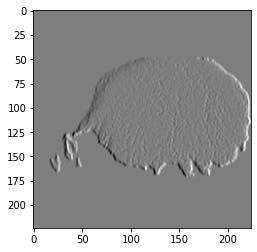

In [73]:
plt.imshow(X_train[0], cmap = "gray")

In [57]:
X_train[0].shape

(224, 224, 1)

## Normalisation et encoding

In [58]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [59]:
y_train = to_categorical(y_train,5)[:,-2:]
y_val = to_categorical(y_val,5)[:,-2:]
y_test = to_categorical(y_test,5)[:,-2:]

## Data augmentation

In [60]:
augmenter = HairGenerator()

In [61]:
augmenter.datagen(X_train, y_train, batch_size=16, rotation_range=20, width_shift_range=0.1,
                  height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest',
                  brightness_range=None)

## Model

In [62]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [63]:
def initialize_model():
   
    model  = models.Sequential()
    
    ### First convolution & max-pooling
    model.add(layers.Conv2D(16, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 1), padding = "same"))
    #model.add(layers.Dropout(rate=0.2))
    
    ### Second convolution
    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (2,2)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Third convolution
    model.add(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding = "same"))  
    #model.add(layers.Dropout(rate=0.2))
    
    ### Fourth convolution
    model.add(layers.Conv2D(32, kernel_size=(2, 2), activation='relu', padding = "same"))
    model.add(layers.MaxPool2D(pool_size = (4,4)))    
    #model.add(layers.Dropout(rate=0.2))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One fully connected
    model.add(layers.Dense(32, activation='relu')) 
    model.add(layers.Dropout(rate=0.2))

    ### Last layer
    model.add(layers.Dense(2, activation='sigmoid')) 

    model.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(learning_rate = 0.0001),
            metrics=['accuracy'])
    
    return model

In [64]:
model = initialize_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 16)      272       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 32)      4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)            

In [65]:
# learning rate schedule
def step_decay(epoch, lr):
    decay = 0.5
    lr *= (1. / (1. + decay * epoch))
    return lr

In [69]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor = "val_loss")
lrate = LearningRateScheduler(step_decay)
callbacks_list = []
history = model.fit(augmenter.hair_flow, validation_data = (X_val, y_val),
          epochs=100, batch_size=8, verbose=1, callbacks = callbacks_list)

Epoch 1/100
13/13 [==============================] - 9s 665ms/step - loss: 0.6494 - accuracy: 0.5950 - val_loss: 0.6853 - val_accuracy: 0.5517
Epoch 2/100
13/13 [==============================] - 10s 731ms/step - loss: 0.6616 - accuracy: 0.5600 - val_loss: 0.6786 - val_accuracy: 0.6322
Epoch 3/100
13/13 [==============================] - 10s 758ms/step - loss: 0.6534 - accuracy: 0.6100 - val_loss: 0.6830 - val_accuracy: 0.6092
Epoch 4/100
13/13 [==============================] - 9s 702ms/step - loss: 0.6455 - accuracy: 0.6350 - val_loss: 0.6888 - val_accuracy: 0.5747
Epoch 5/100
13/13 [==============================] - 10s 799ms/step - loss: 0.6248 - accuracy: 0.6450 - val_loss: 0.6984 - val_accuracy: 0.5747
Epoch 6/100
13/13 [==============================] - 10s 780ms/step - loss: 0.6397 - accuracy: 0.6100 - val_loss: 0.7130 - val_accuracy: 0.5862
Epoch 7/100
13/13 [==============================] - 10s 829ms/step - loss: 0.6319 - accuracy: 0.6550 - val_loss: 0.7083 - val_accuracy: 0

Epoch 58/100
13/13 [==============================] - 10s 776ms/step - loss: 0.5271 - accuracy: 0.7450 - val_loss: 0.8985 - val_accuracy: 0.6092
Epoch 59/100
13/13 [==============================] - 10s 747ms/step - loss: 0.4873 - accuracy: 0.7400 - val_loss: 0.9314 - val_accuracy: 0.6092
Epoch 60/100
13/13 [==============================] - 8s 648ms/step - loss: 0.5018 - accuracy: 0.7400 - val_loss: 0.9563 - val_accuracy: 0.5977
Epoch 61/100
13/13 [==============================] - 8s 648ms/step - loss: 0.5059 - accuracy: 0.7500 - val_loss: 0.9399 - val_accuracy: 0.5862
Epoch 62/100
13/13 [==============================] - 9s 703ms/step - loss: 0.5422 - accuracy: 0.7500 - val_loss: 0.9766 - val_accuracy: 0.5977
Epoch 63/100
13/13 [==============================] - 9s 683ms/step - loss: 0.5151 - accuracy: 0.7600 - val_loss: 0.9228 - val_accuracy: 0.6092
Epoch 64/100
13/13 [==============================] - 9s 687ms/step - loss: 0.5262 - accuracy: 0.7400 - val_loss: 0.9220 - val_accurac

## plot_history(history)

In [70]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 205ms/step - loss: 0.5913 - accuracy: 0.7480


[0.5913227796554565, 0.7479674816131592]

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

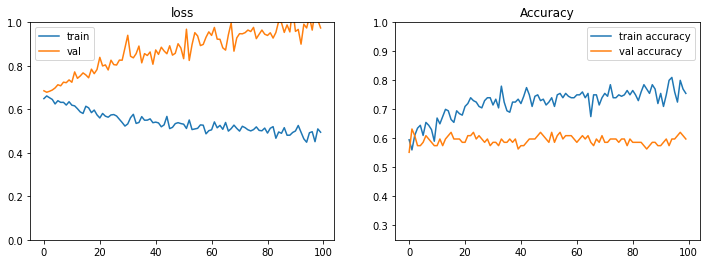

In [71]:
plot_history(history)

In [54]:
#model.save_weights("/home/aymeric/code/Aymeric-B/elle_ebene/model_weights/seg_aug_prewitt/weights")